# 模型评估完整教程 - 分类器性能评估

## 🎯 学习目标
- 理解分类器评估的重要性
- 掌握交叉验证的原理和应用
- 学会使用混淆矩阵分析模型性能
- 理解精确率、召回率和F1分数
- 掌握ROC曲线和AUC指标

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

print("✅ 库导入成功！")

✅ 库导入成功！


## 📊 第一部分：数据集读取

我们将使用经典的MNIST手写数字数据集来演示模型评估技术。

### 数据集特点：
- **数据类型**：手写数字图像
- **图像尺寸**：28×28像素的灰度图
- **样本数量**：70,000个样本
- **类别数量**：10个数字（0-9）

📊 正在加载 MNIST 数据集...


✅ 数据加载完成！
   - 数据形状: (70000, 784)
   - 标签形状: (70000,)
   - 数据类型: int64, object
   - 标签类别: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


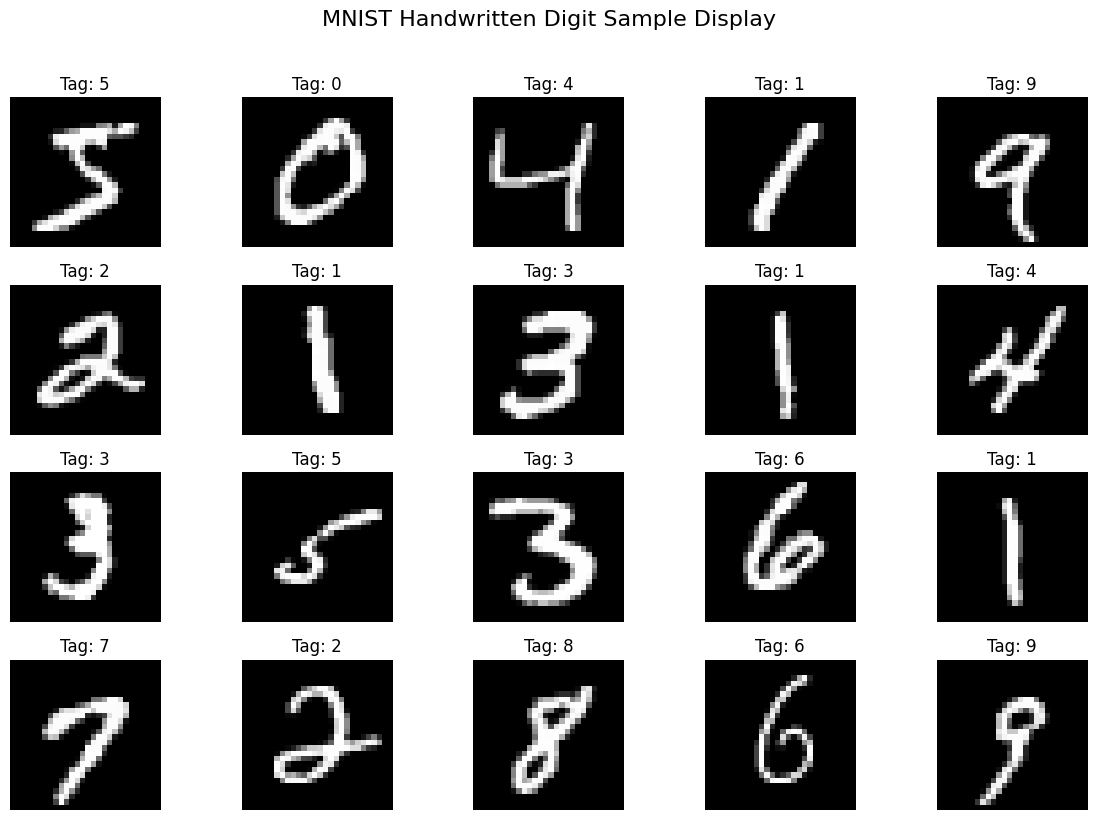

💡 小贴士：每个数字都是28x28=784个像素点组成的！


In [14]:
# 加载MNIST数据集
print('📊 正在加载 MNIST 数据集...')
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist["data"], mnist["target"]

print(f'✅ 数据加载完成！')
print(f'   - 数据形状: {X.shape}')
print(f'   - 标签形状: {y.shape}')
print(f'   - 数据类型: {X.dtype}, {y.dtype}')
print(f'   - 标签类别: {np.unique(y)}')

# 🎨 可视化一些手写数字样本
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    # 将784维向量重塑为28x28图像
    digit_image = X[i].reshape(28, 28)
    plt.imshow(digit_image, cmap='gray')
    plt.title(f'Tag: {y[i]}', fontsize=12)
    plt.axis('off')

plt.suptitle('MNIST Handwritten Digit Sample Display', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
print('💡 小贴士：每个数字都是28x28=784个像素点组成的！')

 数据分割结果：
   - 训练集: (56000, 784)
   - 测试集: (14000, 784)


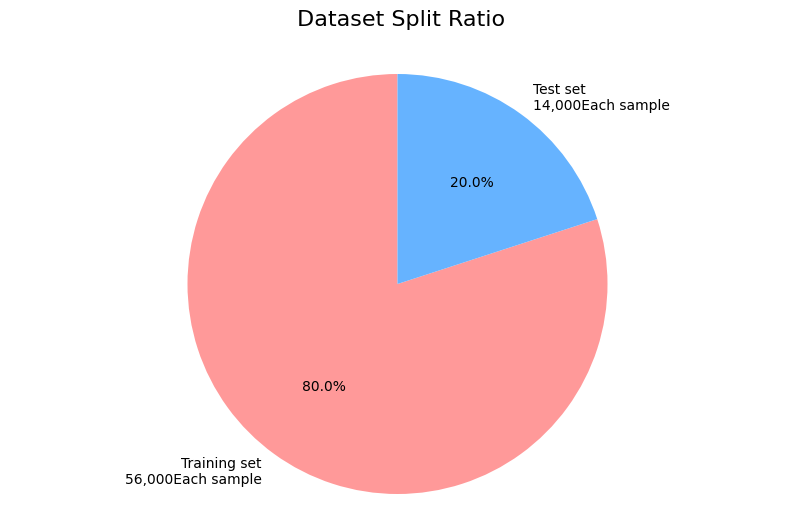

In [17]:
# 数据分割：80%训练，20%测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f' 数据分割结果：')
print(f'   - 训练集: {X_train.shape}')
print(f'   - 测试集: {X_test.shape}')

# 📊 可视化数据分割
plt.figure(figsize=(10, 6))
sizes = [X_train.shape[0], X_test.shape[0]]
labels = [f'Training set\n{X_train.shape[0]:,}Each sample', f'Test set\n{X_test.shape[0]:,}Each sample']
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(' Dataset Split Ratio', fontsize=16, pad=20)
plt.axis('equal')
plt.show()


🎯 二元分类目标创建完成：
   - 训练集标签分布: [50960  5040]
   - 非5的数量: 50960
   - 数字5的数量: 5040


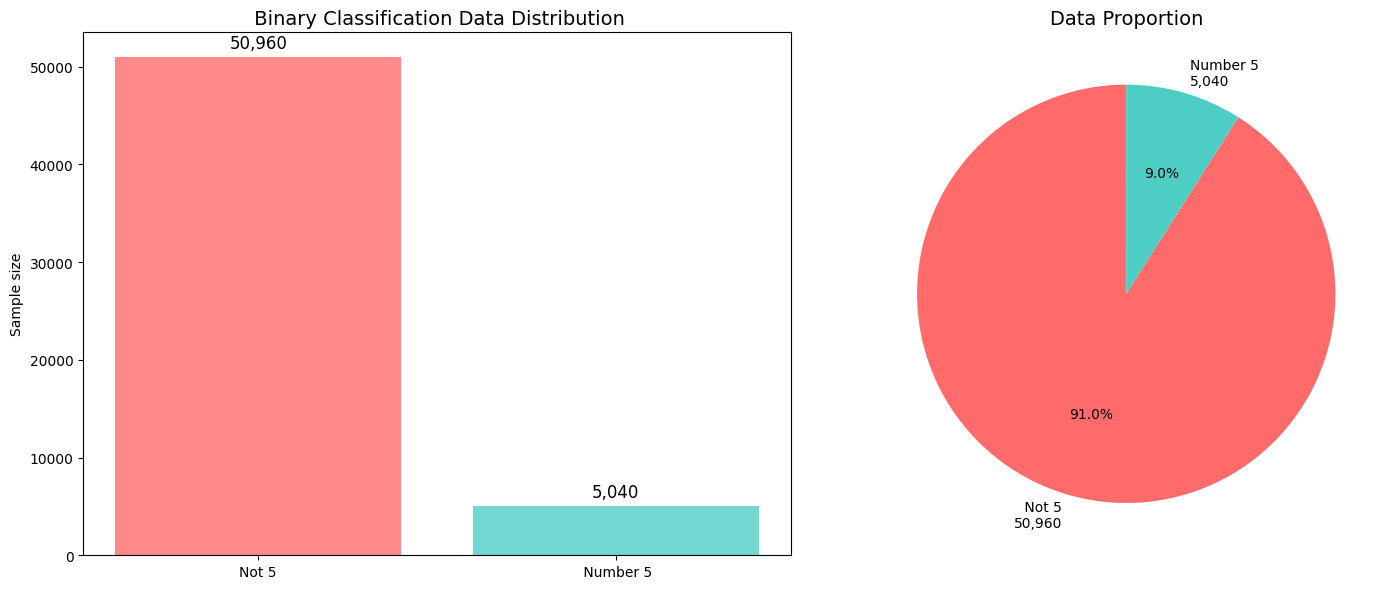

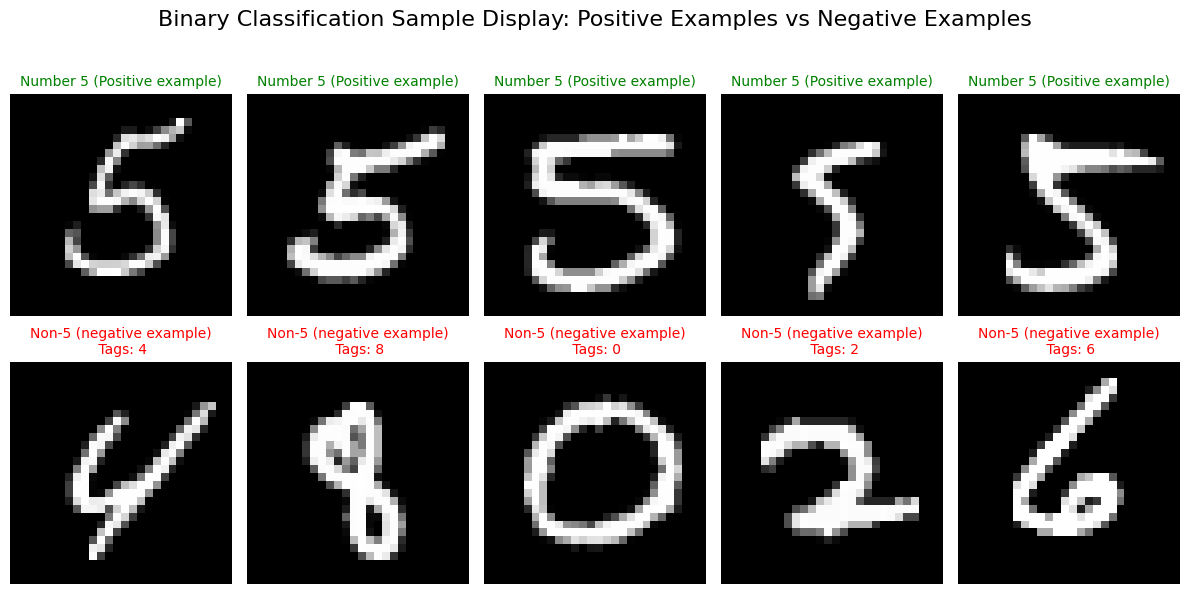

In [19]:
# 创建二元分类目标（是否为数字5）
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

print(f'🎯 二元分类目标创建完成：')
print(f'   - 训练集标签分布: {np.bincount(y_train_5.astype(int))}')
print(f'   - 非5的数量: {(~y_train_5).sum()}')
print(f'   - 数字5的数量: {y_train_5.sum()}')

# 📊 可视化二元分类数据分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 左图：柱状图
counts = np.bincount(y_train_5.astype(int))
labels = ['Not 5', ' Number 5']
colors = ['#ff6b6b', '#4ecdc4']
bars = ax1.bar(labels, counts, color=colors, alpha=0.8)
ax1.set_title(' Binary Classification Data Distribution', fontsize=14)
ax1.set_ylabel('Sample size')

# 添加数值标签
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'{count:,}', ha='center', va='bottom', fontsize=12)

# 右图：饼图
ax2.pie(counts, labels=[f' Not 5\n{counts[0]:,}', f'Number 5\n{counts[1]:,}'], 
         colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Data Proportion', fontsize=14)

plt.tight_layout()
plt.show()

# 📸 展示一些数字5和非5的样本
plt.figure(figsize=(12, 6))

# 找到数字5的索引
digit_5_indices = np.where(y_train == '5')[0][:5]
non_5_indices = np.where(y_train != '5')[0][:5]

# 显示数字5
for i, idx in enumerate(digit_5_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Number 5 (Positive example)', color='green', fontsize=10)
    plt.axis('off')

# 显示非5
for i, idx in enumerate(non_5_indices):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Non-5 (negative example)\n Tags: {y_train[idx]}', color='red', fontsize=10)
    plt.axis('off')

plt.suptitle('Binary Classification Sample Display: Positive Examples vs Negative Examples', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 🔄 第二部分：交叉验证

交叉验证是评估机器学习模型性能的重要技术，它能帮助我们：
- 更准确地估计模型性能
- 检测过拟合问题
- 选择最佳模型参数

In [20]:
# 训练SGD分类器
print('🚀 开始训练 SGD 分类器...')
sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)
print('✅ SGD分类器训练完成！')

🚀 开始训练 SGD 分类器...


✅ SGD分类器训练完成！


正在进行交叉验证...


交叉验证结果：
 - 各折分数: [0.95651786 0.96232143 0.96392857 0.93303571 0.97125   ]
 - 平均分数: 0.9574 (±0.0131)


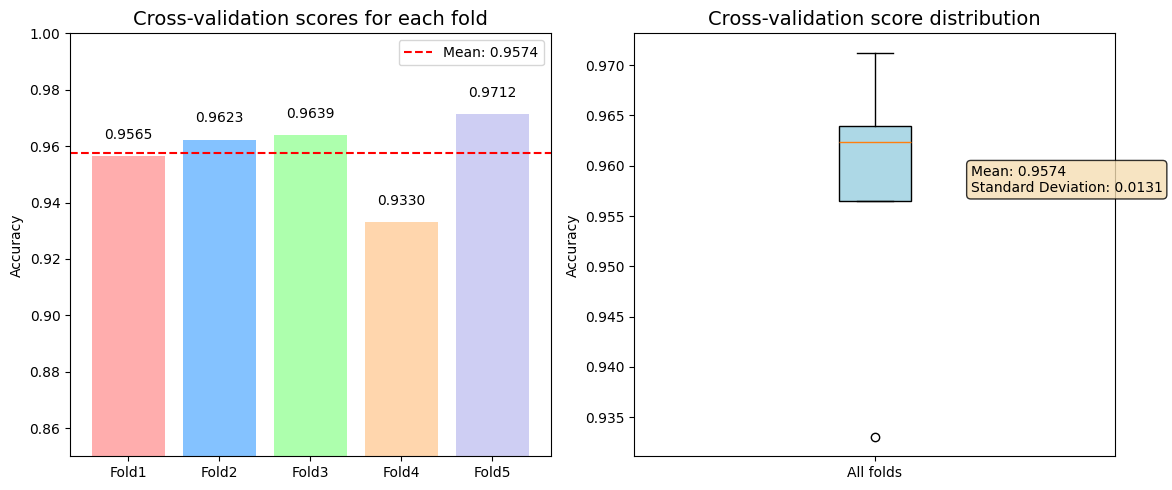

In [21]:
# 使用分层交叉验证评估模型 (Use stratified cross-validation to evaluate the model)
print('正在进行交叉验证...')  # Cross-validation in progress...
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=cv, scoring="accuracy")

print(f'交叉验证结果：')  # Cross-validation results:
print(f' - 各折分数: {scores}')  # Scores for each fold:
print(f' - 平均分数: {scores.mean():.4f} (±{scores.std():.4f})')  # Average score:

# 可视化交叉验证结果 (Visualize cross-validation results)
plt.figure(figsize=(12, 5))

# 左图: 各折分数 (Left figure: Scores for each fold)
plt.subplot(1, 2, 1)
fold_names = [f'Fold{i+1}' for i in range(len(scores))]
bars = plt.bar(fold_names, scores, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'], alpha=0.8)
plt.axhline(y=scores.mean(), color='red', linestyle='--', label=f'Mean: {scores.mean():.4f}')
plt.title('Cross-validation scores for each fold', fontsize=14)  # Cross-validation scores for each fold
plt.ylabel('Accuracy')  # Accuracy
plt.ylim(0.85, 1.0)
plt.legend()

# 添加数据标签 (Add data labels)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

# 右图: 箱线图 (Right figure: Box plot)
plt.subplot(1, 2, 2)
box_plot = plt.boxplot(scores, patch_artist=True)
# Fix: change '#lightblue' to 'lightblue'
for patch in box_plot['boxes']:
    patch.set_facecolor('lightblue')  
plt.title('Cross-validation score distribution', fontsize=14)  # Distribution of cross-validation scores
plt.ylabel('Accuracy')  # Accuracy
plt.xticks([1], ['All folds'])  # All folds

# 添加统计信息 (Add statistical information)
plt.text(1.2, scores.mean(), f'Mean: {scores.mean():.4f}\nStandard Deviation: {scores.std():.4f}',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


## 📈 第三部分：混淆矩阵

混淆矩阵是评估分类器性能的重要工具，它能清晰地显示：
- 真正例（True Positives）
- 假正例（False Positives）
- 真负例（True Negatives）
- 假负例（False Negatives）

In [22]:
# 获取交叉验证预测结果（用于混淆矩阵）
print('📊 获取交叉验证预测结果...')
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(f'✅ 预测结果获取完成！形状: {y_train_pred.shape}')

📊 获取交叉验证预测结果...


✅ 预测结果获取完成！形状: (56000,)


In [25]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 6.9 MB/s eta 0:00:00a 0:00:01


📊 混淆矩阵：
[[50287   673]
 [ 1180  3860]]

📈 混淆矩阵解读：
   - 真负例 (TN): 50,287 - 正确分类为非5
   - 假正例 (FP): 673 - 错误分类为5
   - 假负例 (FN): 1,180 - 错误分类为非5
   - 真正例 (TP): 3,860 - 正确分类为5


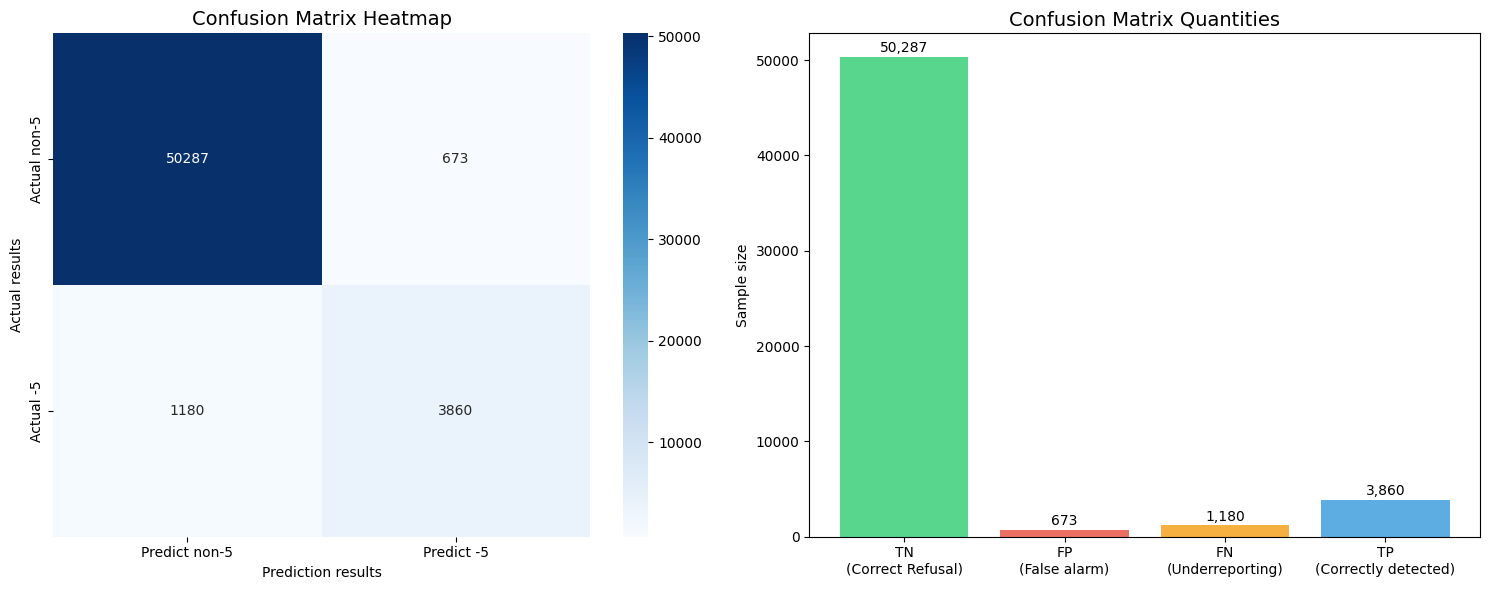


🎯 模型整体表现：
   - 准确率: 0.9669 (96.7%)
   - 错误率: 0.0331 (3.3%)


In [26]:
# 计算混淆矩阵
cm = confusion_matrix(y_train_5, y_train_pred)
print('📊 混淆矩阵：')
print(cm)

# 解读混淆矩阵
tn, fp, fn, tp = cm.ravel()
print(f'\n📈 混淆矩阵解读：')
print(f'   - 真负例 (TN): {tn:,} - 正确分类为非5')
print(f'   - 假正例 (FP): {fp:,} - 错误分类为5')
print(f'   - 假负例 (FN): {fn:,} - 错误分类为非5')
print(f'   - 真正例 (TP): {tp:,} - 正确分类为5')

# 🎨 可视化混淆矩阵
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 左图：热力图
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Predict non-5', 'Predict -5'],
            yticklabels=['Actual non-5', 'Actual -5'])
ax1.set_title('Confusion Matrix Heatmap', fontsize=14)
ax1.set_xlabel('Prediction results')
ax1.set_ylabel('Actual results')

# 右图：柱状图对比
categories = ['TN\n(Correct Refusal)', 'FP\n(False alarm)', 'FN\n(Underreporting)', 'TP\n(Correctly detected)']
values = [tn, fp, fn, tp]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, alpha=0.8)
ax2.set_title('Confusion Matrix Quantities', fontsize=14)
ax2.set_ylabel('Sample size')

# 添加数值标签
for bar, value in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
             f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 📊 计算准确率
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f'\n🎯 模型整体表现：')
print(f'   - 准确率: {accuracy:.4f} ({accuracy:.1%})')
print(f'   - 错误率: {1-accuracy:.4f} ({1-accuracy:.1%})')

## 🎯 第四部分：精确率和召回率

### 核心公式

**精确率 (Precision)**：
$$precision = \frac{TP}{TP + FP}$$

**召回率 (Recall)**：
$$recall = \frac{TP}{TP + FN}$$

### 简单理解
- **精确率**：在所有预测为正例的样本中，真正为正例的比例
- **召回率**：在所有真正为正例的样本中，被正确预测的比例

🎯 模型性能指标：
   - 精确率 (Precision): 0.8515
   - 召回率 (Recall): 0.7659
   - F1分数: 0.8064

📊 指标解读：
   - 精确率: 在所有预测为5的数字中，85.2%是真正的5
   - 召回率: 在所有真正的5中，76.6%被正确识别出来


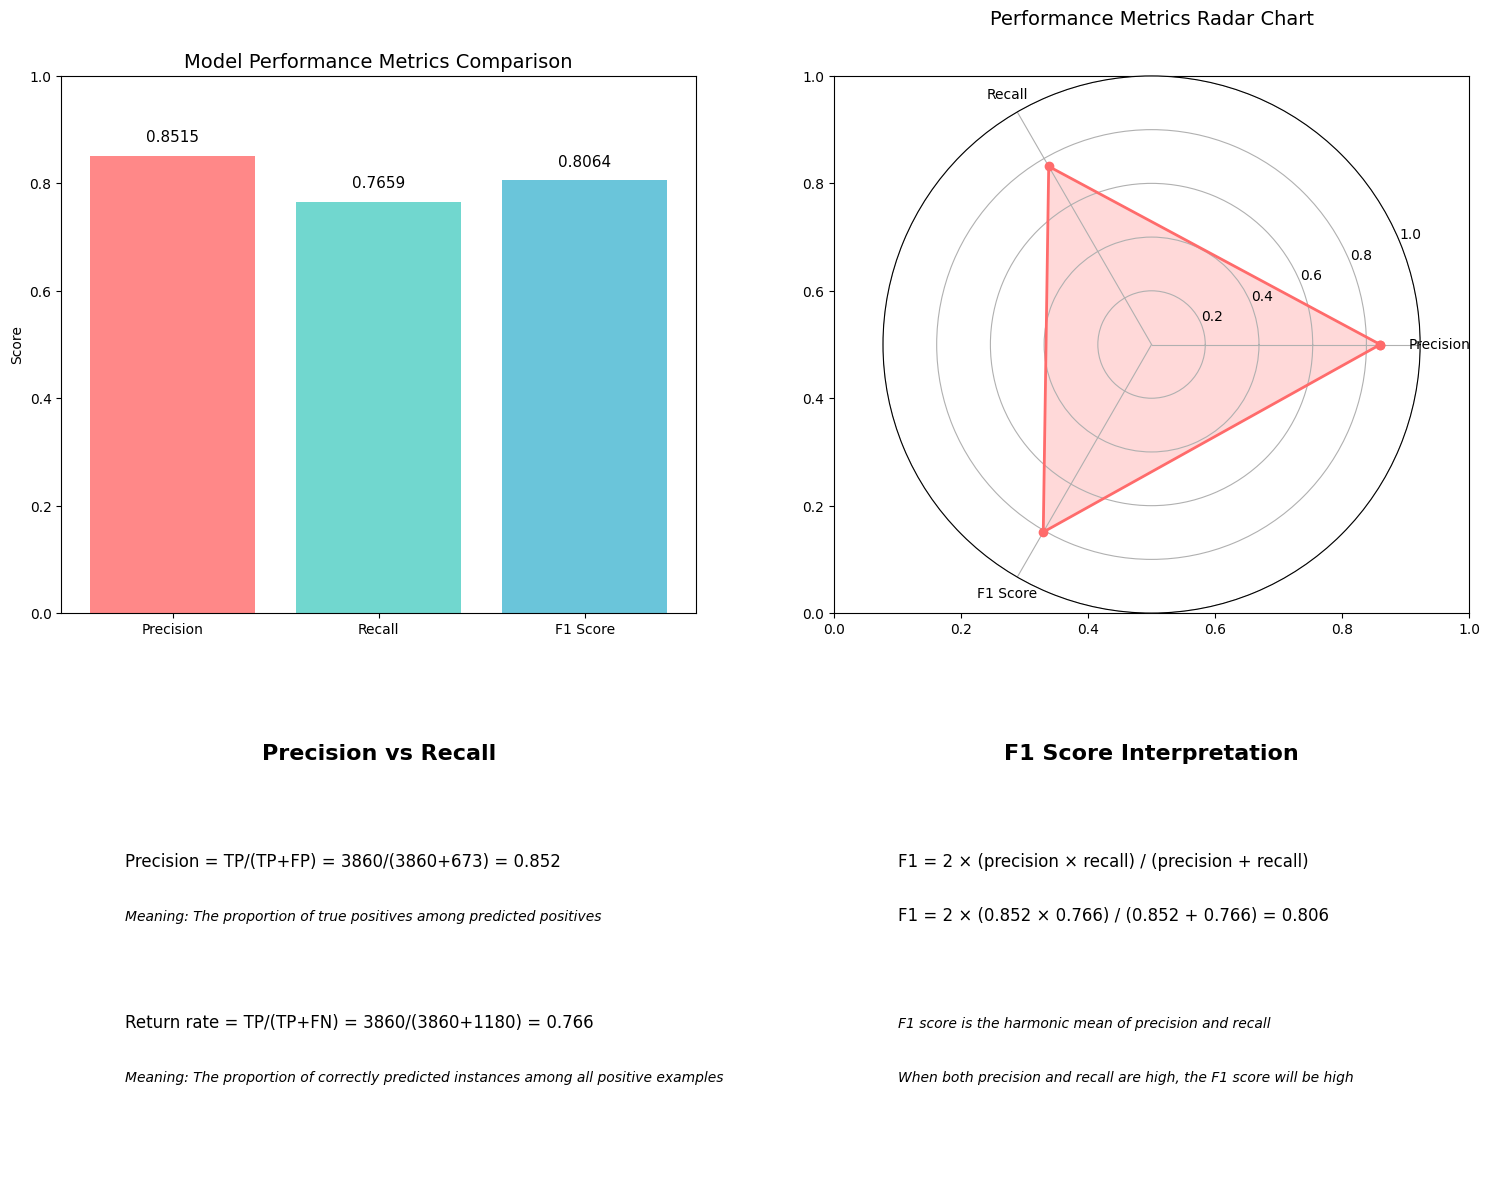

In [27]:
# 计算精确率、召回率和F1分数
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f'🎯 模型性能指标：')
print(f'   - 精确率 (Precision): {precision:.4f}')
print(f'   - 召回率 (Recall): {recall:.4f}')
print(f'   - F1分数: {f1:.4f}')

print(f'\n📊 指标解读：')
print(f'   - 精确率: 在所有预测为5的数字中，{precision:.1%}是真正的5')
print(f'   - 召回率: 在所有真正的5中，{recall:.1%}被正确识别出来')

# 📊 可视化性能指标
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 左上：性能指标对比
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
ax1.set_title('Model Performance Metrics Comparison', fontsize=14)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)

# 添加数值标签
for bar, value in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=11)

# 右上：精确率和召回率的平衡
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
values_radar = values + [values[0]]  # 闭合雷达图
angles += angles[:1]

ax2 = plt.subplot(2, 2, 2, projection='polar')
ax2.plot(angles, values_radar, 'o-', linewidth=2, color='#ff6b6b')
ax2.fill(angles, values_radar, alpha=0.25, color='#ff6b6b')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metrics)
ax2.set_ylim(0, 1)
ax2.set_title('Performance Metrics Radar Chart', y=1.08, fontsize=14)

# 左下：精确率和召回率的意义图解
# 创建一个简化的混淆矩阵图
ax3.text(0.5, 0.8, 'Precision vs Recall', ha='center', fontsize=16, weight='bold', transform=ax3.transAxes)
ax3.text(0.1, 0.6, f'Precision = TP/(TP+FP) = {tp}/({tp}+{fp}) = {precision:.3f}', fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.5, 'Meaning: The proportion of true positives among predicted positives', fontsize=10, transform=ax3.transAxes, style='italic')
ax3.text(0.1, 0.3, f'Return rate = TP/(TP+FN) = {tp}/({tp}+{fn}) = {recall:.3f}', fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.2, 'Meaning: The proportion of correctly predicted instances among all positive examples', fontsize=10, transform=ax3.transAxes, style='italic')
ax3.axis('off')

# 右下：F1分数的意义
ax4.text(0.5, 0.8, 'F1 Score Interpretation', ha='center', fontsize=16, weight='bold', transform=ax4.transAxes)
ax4.text(0.1, 0.6, f'F1 = 2 × (precision × recall) / (precision + recall)', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.5, f'F1 = 2 × ({precision:.3f} × {recall:.3f}) / ({precision:.3f} + {recall:.3f}) = {f1:.3f}', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.3, 'F1 score is the harmonic mean of precision and recall', fontsize=10, transform=ax4.transAxes, style='italic')
ax4.text(0.1, 0.2, 'When both precision and recall are high, the F1 score will be high', fontsize=10, transform=ax4.transAxes, style='italic')
ax4.axis('off')

plt.tight_layout()
plt.show()

## ⚖️ 第五部分：阈值对结果的影响

分类器的决策阈值直接影响精确率和召回率的平衡。
通过调整阈值，我们可以：
- 提高精确率（但可能降低召回率）
- 提高召回率（但可能降低精确率）

In [28]:
# 获取决策分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# 计算精确率-召回率曲线
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print(f'📊 阈值分析完成：')
print(f'   - 精确率数组长度: {len(precisions)}')
print(f'   - 召回率数组长度: {len(recalls)}')
print(f'   - 阈值数组长度: {len(thresholds)}')

📊 阈值分析完成：
   - 精确率数组长度: 56001
   - 召回率数组长度: 56001
   - 阈值数组长度: 56000


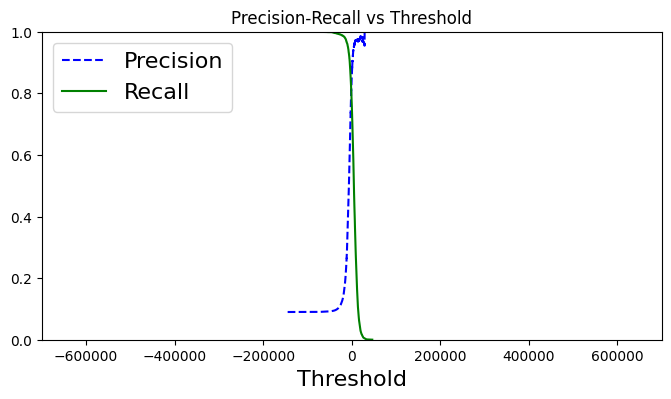

In [29]:
# 绘制精确率-召回率 vs 阈值曲线
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.title('Precision-Recall vs Threshold')
plt.show()

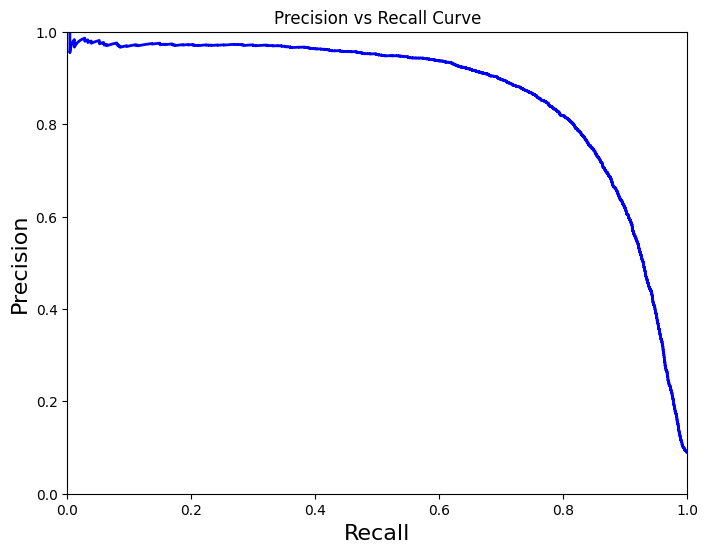

In [30]:
# 绘制精确率 vs 召回率曲线
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('Precision vs Recall Curve')
plt.show()

## 📊 第六部分：ROC曲线

**ROC (Receiver Operating Characteristic)** 曲线是二元分类中的重要评估工具。

### 核心概念
ROC曲线绘制的是：
- **X轴**：假正例率 (False Positive Rate, FPR)
- **Y轴**：真正例率 (True Positive Rate, TPR)

### 计算公式
- **TPR = TP / (TP + FN)** (即召回率)
- **FPR = FP / (FP + TN)**

### 评估标准
- 曲线越靠近左上角，分类器性能越好
- 对角线表示随机分类器的性能

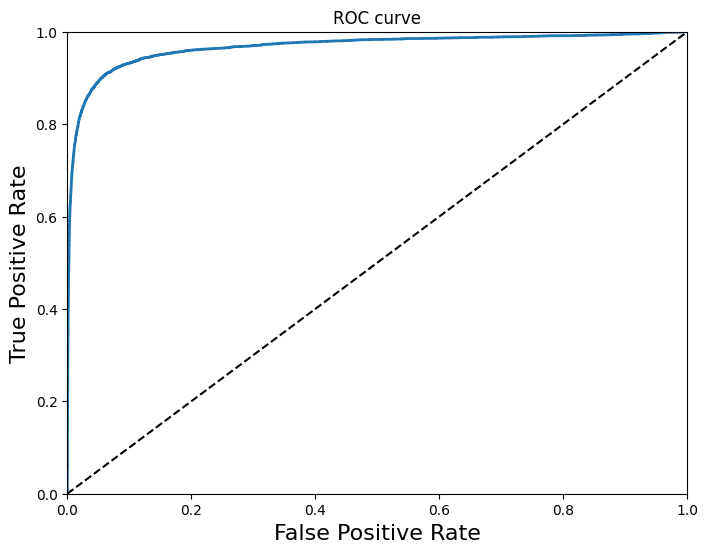

In [31]:
# 计算ROC曲线
fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_scores)

# 绘制ROC曲线
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # 对角线
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('ROC curve')
plt.show()

In [32]:
# 计算AUC值
auc_score = roc_auc_score(y_train_5, y_scores)

print(f'📊 AUC (Area Under Curve) 分数: {auc_score:.4f}')
print(f'\n💡 AUC解读：')
print(f'   - AUC = 1.0: 完美分类器')
print(f'   - AUC = 0.5: 随机分类器')
print(f'   - 当前AUC = {auc_score:.4f}: 表现良好的分类器')

📊 AUC (Area Under Curve) 分数: 0.9673

💡 AUC解读：
   - AUC = 1.0: 完美分类器
   - AUC = 0.5: 随机分类器
   - 当前AUC = 0.9673: 表现良好的分类器


## 🎊 总结

### 你已经学会了：
- ✅ 交叉验证的原理和实现
- ✅ 混淆矩阵的计算和解读
- ✅ 精确率、召回率和F1分数的含义
- ✅ 阈值对模型性能的影响
- ✅ ROC曲线和AUC指标的应用

### 关键要点：
1. **交叉验证**：提供更可靠的性能估计
2. **混淆矩阵**：直观显示分类结果的详细情况
3. **精确率vs召回率**：根据业务需求选择合适的平衡点
4. **ROC曲线**：综合评估分类器在不同阈值下的表现
5. **AUC值**：单一数值总结分类器整体性能

记住：**选择合适的评估指标取决于具体的业务场景和需求！** 🚀